# 🐳 Develop a PCM for the Gulf Stream Extension region

Notebook toward a [Profile Classification Models (PCM)](https://pyxpcm.readthedocs.io/en/latest/overview.html) for the Gulf Stream.

# 🔧 Step 2: fit a PCM and make predictions, i.e. classification

Here we use [pyxpcm](https://pyxpcm.readthedocs.io/) to compute a PCM model of the training assembled in step 1.

In [1]:
import sys, os
import numpy as np
import xarray as xr
xr.set_options(display_style="html", display_expand_attrs=False);
import gsw
import pandas as pd

In [2]:
sys.path.insert(0, "/Users/gmaze/git/github/euroargodev/argopy")
import argopy
# argopy.clear_cache()
argopy.status(refresh=5)
argopy.set_options(ftp='/Volumes/CORIOLIS-GDAC')

/Users/gmaze/miniconda3/envs/virtualfleet/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


HTML(value='<table><tr><td><img src="https://img.shields.io/static/v1?style=flat-square&label=src%20argovis%20…

In [3]:
from pyxpcm.models import pcm

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, "/Users/gmaze/git/github/euroargodev/boundary_currents_pcm")
# sys.path.insert(0, os.sep.join([os.getcwd(), '..', '..']))  # From binder
from pcmbc.utilities import from_stp_2_std, get_regulargrid_dataset, reorder_class
from pcmbc.plot import Plotter

# 🔹 Define the rectangular domain to analyse

The box here should encompasses a larger area that the core of BC current, in order to show to the classifier enough profiles with different structures.

Obviously, this box must be smaller (or equal) than the box used to download data in step 1

In [4]:
# [lon_min, lon_max, lat_min, lat_max]

box = [-75.,-35.,35,50.]  # Gulf Stream Extension

# box = [-1., 5., 35., 42.]  # Western Mediterranean (Extended)
# box = [-0.5, 5.6, 38.8, 41.4]  # Western Mediterranean
# box = [-10., -6., 32., 38.5]  # Gulf of Cadiz (Extended)
# box = [-20., 5. ,69., 77.]  # Nordic Seas (western part)
# box = [-20., 15. , 65., 77.]  # Nordic Seas (Extended)

# 🔹 Load Argo data (see notebook step 1)

In [5]:
dsp = xr.open_dataset(os.sep.join(['data', 'Argo-GulfStreamBox-prof-sdl.nc']))
dsp

<xarray.Dataset>
Dimensions:            (N_PROF: 16176, PRES_INTERPOLATED: 150)
Coordinates:
  * N_PROF             (N_PROF) int64 0 1 2 3 4 ... 16172 16173 16174 16175
    TIME               (N_PROF) datetime64[ns] ...
    LATITUDE           (N_PROF) float64 ...
    LONGITUDE          (N_PROF) float64 ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 10 20 30 ... 1470 1480 1490
Data variables:
    CYCLE_NUMBER       (N_PROF) int32 ...
    DATA_MODE          (N_PROF) object ...
    DIRECTION          (N_PROF) object ...
    PLATFORM_NUMBER    (N_PROF) int32 ...
    PRES               (N_PROF, PRES_INTERPOLATED) float64 ...
    PSAL               (N_PROF, PRES_INTERPOLATED) float64 ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float64 ...
Attributes: (8)

# 🔹 Prepare a PCM (classifier)

In [6]:
# Define variables to be used by classifier:

# a vertical depth axis:
# (must be negative and oriented downard)
pcm_dpt_axis = np.arange(0.,-1450,-10.)   # Looks good for GS

# and measurements:
# pcm_features = {'temperature': pcm_dpt_axis}
# pcm_features = {'salinity': pcm_dpt_axis}
pcm_features = {'temperature': pcm_dpt_axis, 'salinity': pcm_dpt_axis}

# The above means that we're using the [0/z]m T/S data to automatically classify profiles

In [7]:
# Init a PCM classifier, here with k=3 classes:
# m = pcm(K=4, features=pcm_features)
m = pcm(K=4, features=pcm_features, timeit=True, timeit_verb=0, backend='dask_ml')
m

<pcm 'gmm' (K: 4, F: 2)>
Number of class: 4
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'dask_ml.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'dask_ml.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'dask_ml.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'dask_ml.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

# 🔹 Prepare training set for this PCM, from Argo profiles

May be this is a long step, and prepared data could be saved on disk ofr later re-used and gain of time

In [8]:
# Convert dataset standard pressures to standard depths levels
dsi = from_stp_2_std(dsp)
dsi

<xarray.Dataset>
Dimensions:             (N_PROF: 16176, DEPTH_INTERPOLATED: 150)
Coordinates:
  * N_PROF              (N_PROF) int64 0 1 2 3 4 ... 16172 16173 16174 16175
    TIME                (N_PROF) datetime64[ns] 2001-04-28T21:56:21.690000 .....
    LATITUDE            (N_PROF) float64 48.38 40.14 42.89 ... 45.23 39.4 49.0
    LONGITUDE           (N_PROF) float64 -35.77 -56.49 -38.3 ... -70.23 -48.22
  * DEPTH_INTERPOLATED  (DEPTH_INTERPOLATED) float64 -0.0 -9.916 ... -1.472e+03
Data variables:
    CYCLE_NUMBER        (N_PROF) int32 23 11 9 11 9 9 9 ... 155 41 45 93 45 52
    DATA_MODE           (N_PROF) object 'D' 'D' 'D' 'D' 'D' ... 'R' 'R' 'R' 'R'
    DIRECTION           (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER     (N_PROF) int32 69023 4900235 4900259 ... 4902502 4902504
    PRES                (N_PROF, DEPTH_INTERPOLATED) float64 ...
    PSAL                (N_PROF, DEPTH_INTERPOLATED) float64 ...
    TEMP                (N_PROF, DEPTH_INTERPOLATED) float64 ...
Attributes: (8)

In [9]:
%%time
# Since we have a lot of profiles, we're going to work with 'independant' profiles
# ie profiles with a minimal distance from each others, ensuring statistical independance of the training samples
corr_dist = 50 # km
ds_training = get_regulargrid_dataset(dsi, corr_dist)
ds_training['N_PROF'] = np.arange(len(ds_training['N_PROF']))
# ds_t = get_regulargrid_dataset(dsp, corr_dist, season=['DJF'])
print("%i profiles in the training set" % len(ds_training['N_PROF']))

849 profiles in the training set
CPU times: user 15.6 s, sys: 1.24 s, total: 16.8 s
Wall time: 16.6 s


## Have a quick look to the "training set"

No worries for NaNs, these are handled by the pyXpcm librairy

But be careful with outliers ! PCM will tend to attribute an entire class to a specific outlier, messing up the analysis

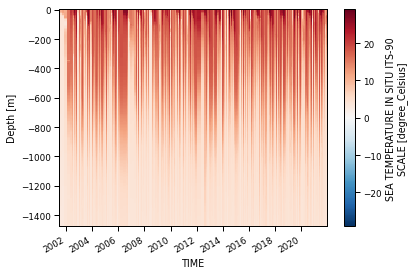

In [10]:
ds_training.sortby('TIME')['TEMP'].plot(x='TIME')

In [11]:
# ds_training.sortby('TIME')['PSAL'].plot(x='TIME')

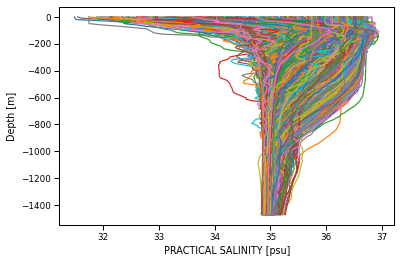

In [12]:
ds_training.sortby('TIME')['PSAL'].plot(y='DEPTH_INTERPOLATED', hue='TIME', add_legend=False);

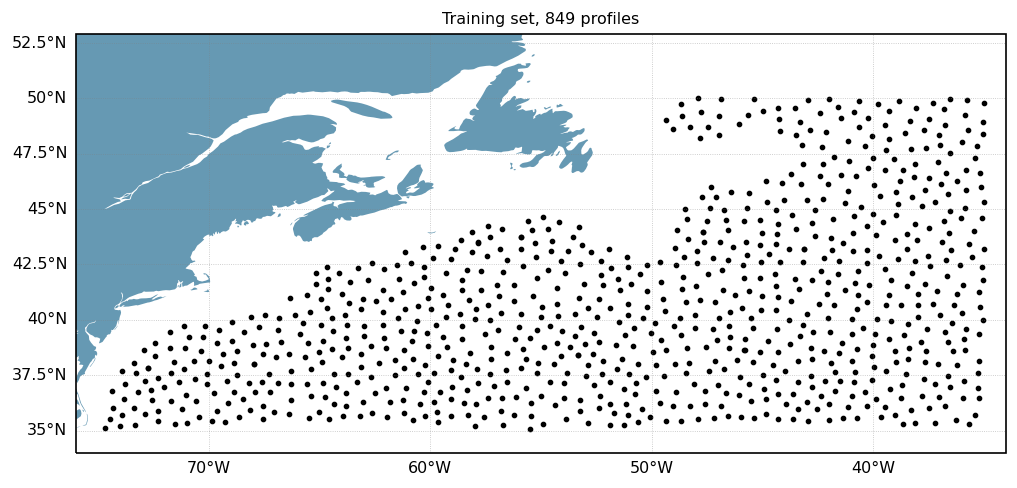

In [13]:
proj = argopy.plot.utils.cartopy.crs.PlateCarree()
dx, dy = 1, 1  # How much to extent the map contours wrt to the data set real domain
subplot_kw={'projection': proj, 'extent': np.array(box) + np.array([-dx,+dx,-dy,+dy])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

ax.plot(ds_training['LONGITUDE'], ds_training['LATITUDE'], 'k.', transform=proj)
argopy.plot.utils.latlongrid(ax)
ax.add_feature(argopy.plot.utils.land_feature)
ax.set_title('Training set, %i profiles' % len(ds_training['N_PROF']))
plt.show()

# 🔹 Compute parameters of the PCM

This is the un-supervised fit of the classifier parameters on training data

In [14]:
%%time

# Tells PCM where to find data on the training set "dsi":
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}
features_zdim = 'DEPTH_INTERPOLATED'

# Make the fit:
m.fit_predict(ds_training, features=features_in_ds, dim=features_zdim, inplace=True)
m

CPU times: user 654 ms, sys: 1.61 s, total: 2.27 s
Wall time: 385 ms


<pcm 'gmm' (K: 4, F: 2)>
Number of class: 4
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'dask_ml.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'dask_ml.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'dask_ml.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'dask_ml.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 25.776179

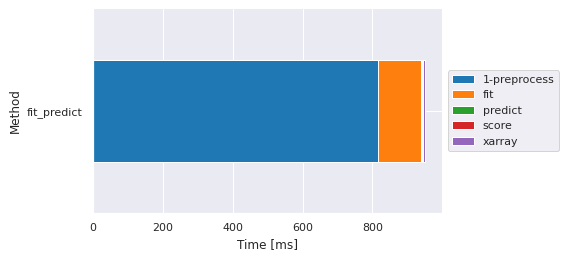

In [15]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split    

# 🔹 Compute classification results (labels, probabilities)

i.e. apply the PCM classifier to the full dataset

In [16]:
# Predict labels and proba:
m.predict(dsi, features=features_in_ds, dim=features_zdim, inplace = True)
m.predict_proba(dsi, features=features_in_ds, dim=features_zdim, inplace = True)

# Compute robustness:
dsi.pyxpcm.robustness(m, inplace = True)
dsi.pyxpcm.robustness_digit(m, inplace = True)

# and further compute the "typical" profiles of each classes, using quantiles of profiles:
for vname in ['TEMP', 'PSAL']:
    dsi = dsi.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)

In [17]:
def reduce_by_lat(this_ds):
    """Reduce a dataset to a single metric value: maximum latitude"""
    return np.nanmax(this_ds['LATITUDE'])
    
def reduce_by_temp(this_ds):
    """Reduce a dataset to a single metric value: median of vertical mean temperature"""
    return this_ds['TEMP'].mean('DEPTH_INTERPOLATED').median().values[np.newaxis][0]

dsi = reorder_class(dsi, m, reduce_by_temp)

[9.88339217014729, 6.740484673222856, 12.682145442063366, 10.764864326501243] [1 0 3 2]


# 🔹 Visualize results

## Simplest figures

### Typical profiles of each classes

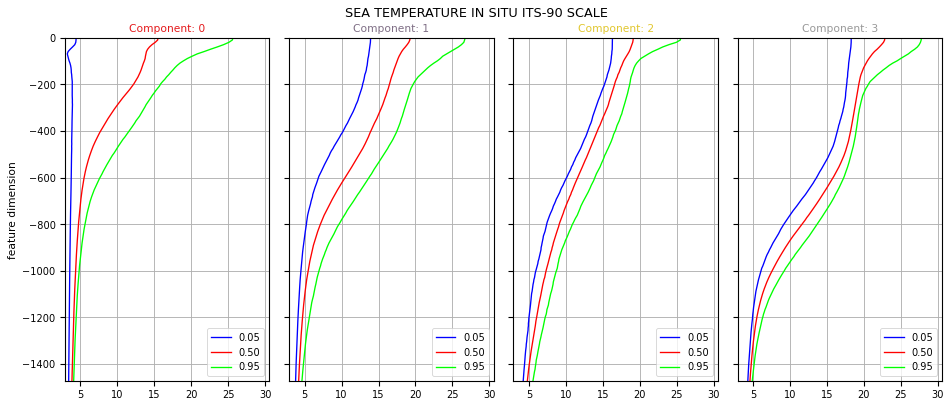

In [18]:
fig, ax = m.plot.quantile(dsi['TEMP_Q'], maxcols=4, figsize=(12, 5), sharey=True)
fig.suptitle(dsp['TEMP'].attrs['long_name'], verticalalignment='bottom');

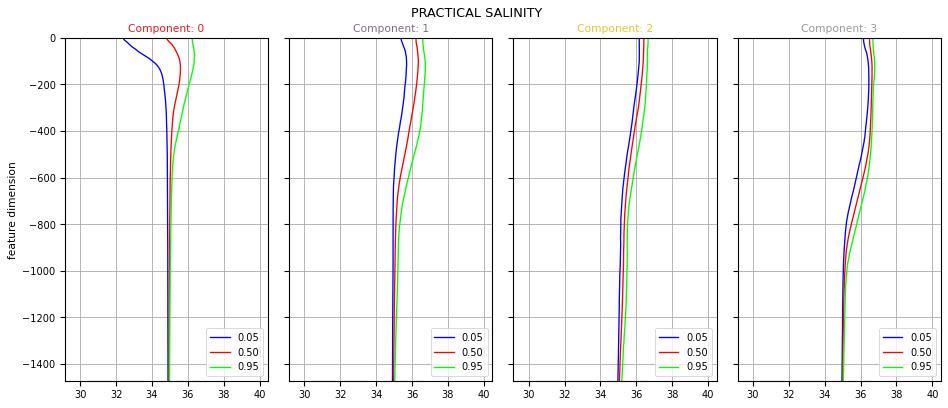

In [19]:
fig, ax = m.plot.quantile(dsi['PSAL_Q'], maxcols=4, figsize=(12, 5), sharex=True, sharey=True)
# ax[0].set_xlim([34, 36])
# ax[0].set_xlim([35, 37])
fig.suptitle(dsp['PSAL'].attrs['long_name'], verticalalignment='bottom');

### Spatial distribution of profiles colored by the class/label they've been attributed to

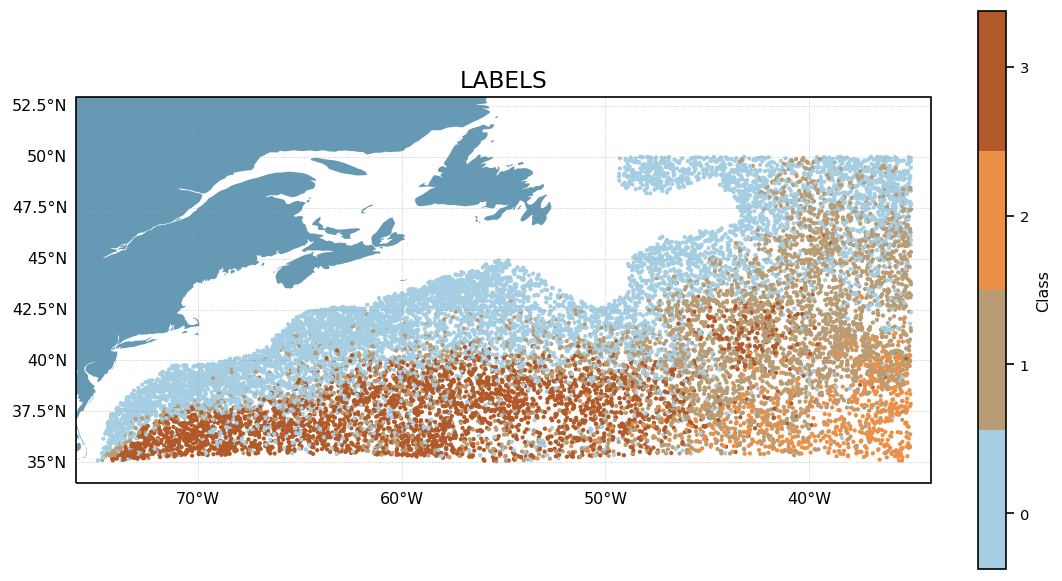

In [50]:
proj = argopy.plot.utils.cartopy.crs.PlateCarree()
dx, dy = 1, 1  # How much to extent the map contours wrt to the data set real domain
subplot_kw={'projection': proj, 'extent': np.array(box) + np.array([-dx,+dx,-dy,+dy])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cname = 'Paired'
sc = ax.scatter(dsi['LONGITUDE'], dsi['LATITUDE'], s=3, c=dsi['PCM_LABELS'], cmap=m.plot.cmap(name=cname), transform=proj, vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax, name=cname)
argopy.plot.utils.latlongrid(ax)
ax.add_feature(argopy.plot.utils.land_feature)
ax.set_title('LABELS', fontsize=14)
plt.show()

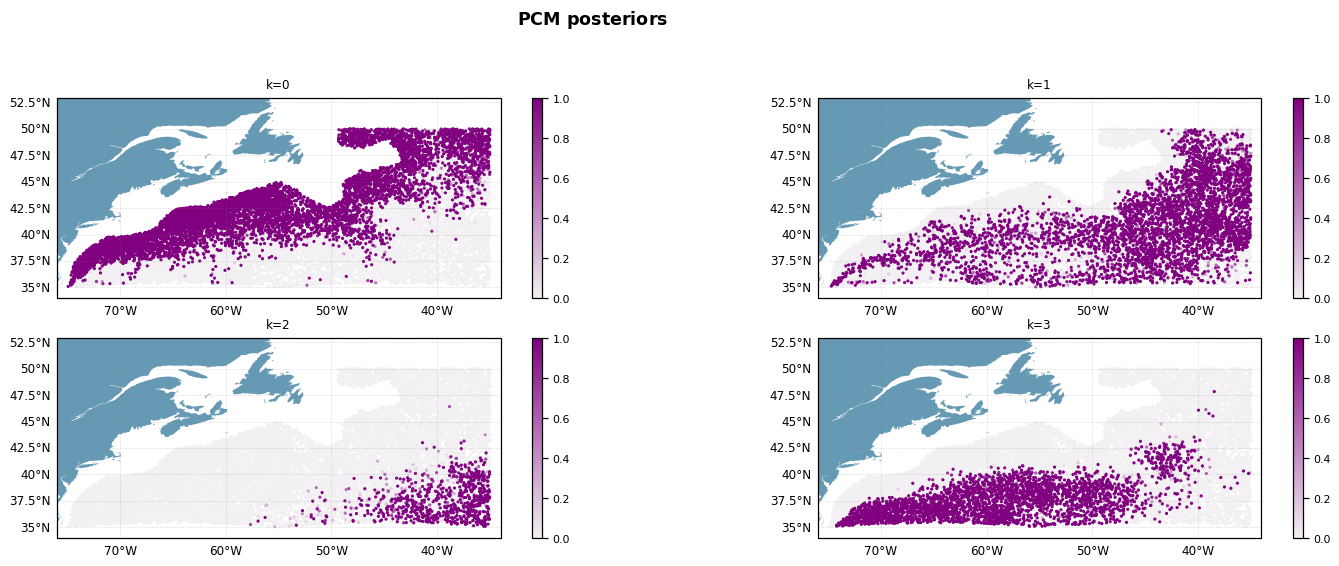

In [49]:
cmap = sns.light_palette("purple", as_cmap=True)
proj = argopy.plot.utils.cartopy.crs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array(box) + np.array([-dx,+dx,-dy,+dy])}
fig, ax = m.plot.subplots(figsize=(20,10), maxcols=2, subplot_kw=subplot_kw, dpi=90)

for k in m:
    this_ds = dsi.sel(pcm_class=k).sortby('PCM_POST')
    sc = ax[k].scatter(this_ds['LONGITUDE'], this_ds['LATITUDE'], s=3, c=this_ds['PCM_POST'],
                       cmap=cmap, transform=proj, vmin=0, vmax=1)
    cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
    argopy.plot.utils.latlongrid(ax[k])
    ax[k].add_feature(argopy.plot.utils.land_feature)
    ax[k].set_title('k=%i' % k)
    
# fig.suptitle('PCM posteriors', fontsize=14);
fig.suptitle('$\\bf{PCM\\ posteriors}$', fontsize=14);

## More figures with the plot helper class

In [51]:
P = Plotter(dsi, m, coords_dict={'latitude': 'LATITUDE', 'longitude': 'LONGITUDE', 'time': 'TIME', 'depth': 'DEPTH_INTERPOLATED'}, cmap_name=cname)
# P = Plotter(ds_training, m, coords_dict={'latitude': 'LATITUDE', 'longitude': 'LONGITUDE', 'time': 'TIME', 'depth': 'DEPTH_INTERPOLATED'}, 
    # cmap_name=cname)

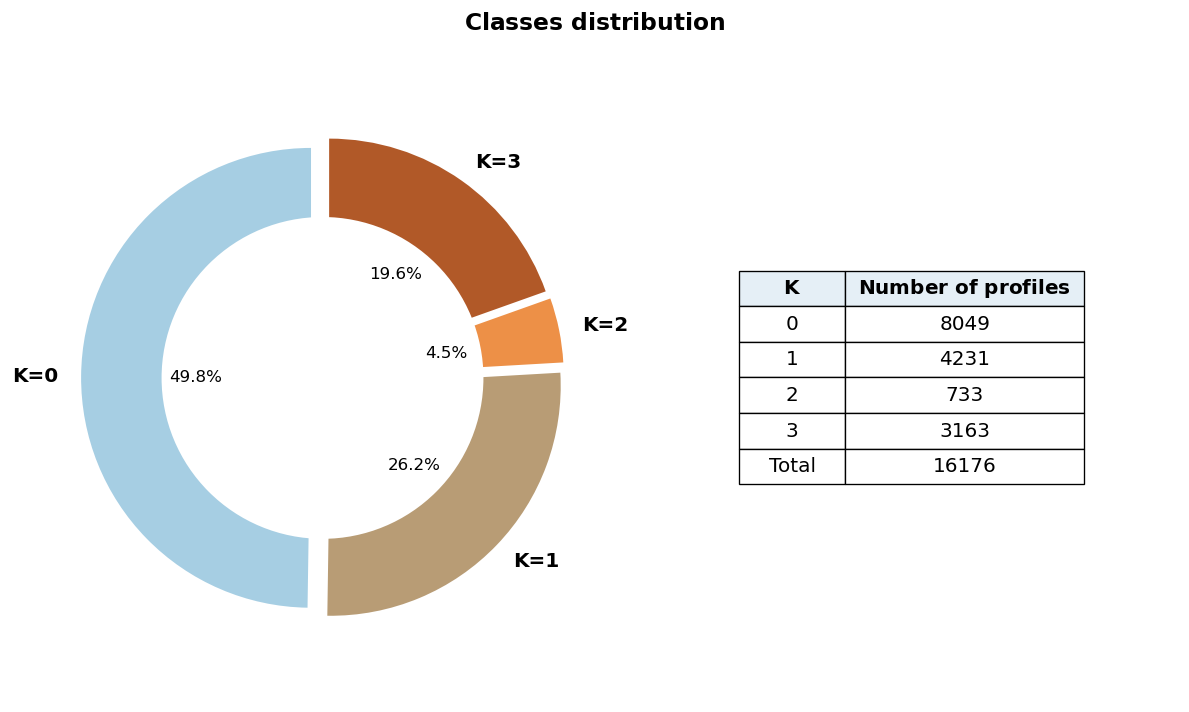

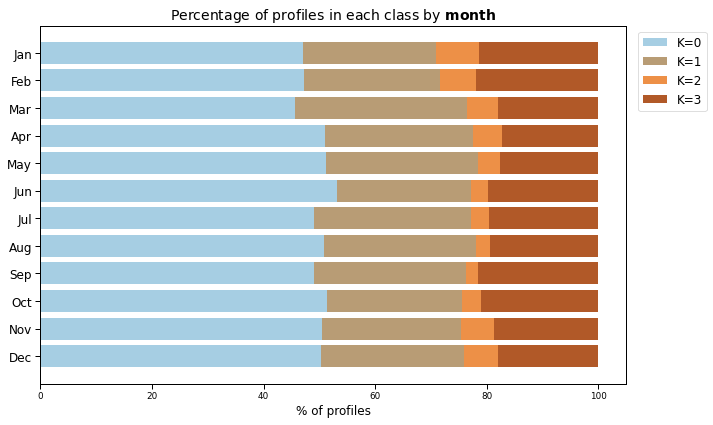

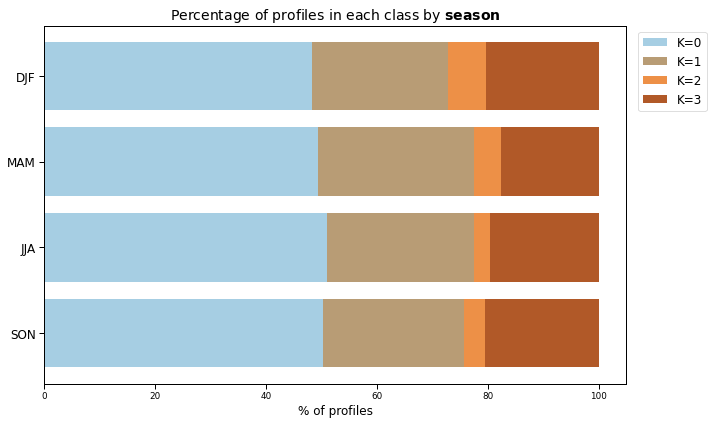

In [52]:
P.pie_classes()
P.temporal_distribution(time_bins='month');
P.temporal_distribution(time_bins='season');

In [53]:
# P.vertical_structure(q_variable='TEMP_Q', sharey=True, ylim=[-1000, 0], figsize=(10,5), xlabel=dsp['TEMP'].attrs['long_name'])
# P.vertical_structure(q_variable='PSAL_Q', sharey=True, ylim=[-1000, 0], figsize=(10,5), xlabel=dsp['PSAL'].attrs['long_name'])

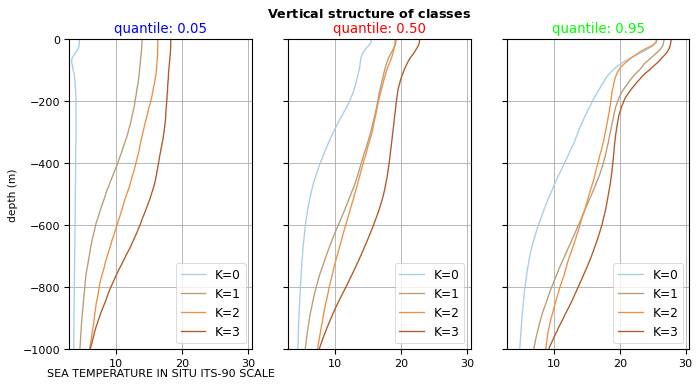

In [54]:
P.vertical_structure_comp(q_variable='TEMP_Q', sharey=True, ylim=[-1000, 0], figsize=(10,5), xlabel=dsp['TEMP'].attrs['long_name']);

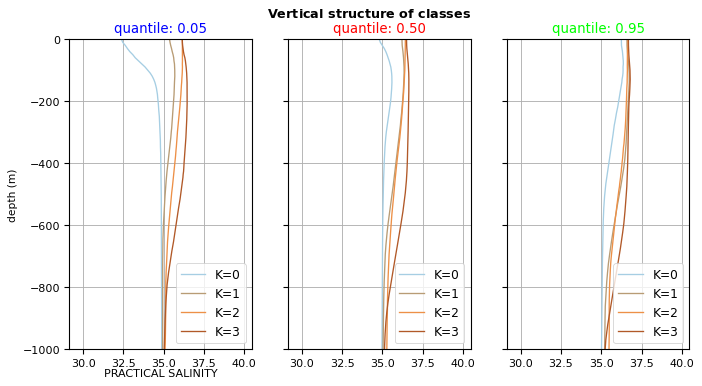

In [55]:
P.vertical_structure_comp(q_variable='PSAL_Q', sharey=True, ylim=[-1000, 0], figsize=(10,5), xlabel=dsp['PSAL'].attrs['long_name']);

# 🔹 Save this PCM on file for later classification of new profiles

In [ ]:
m.to_netcdf('my_pcm.nc', global_attributes={'project': 'EARISE'})
# This netcdf file is complex and not meant to be open directly, instead use the pyxpcm.load_netcdf function

# Troubles shooting

- the most common weird thing is to see a classification that is different between several run of the notebook (or fit). In this case:
    - make sure that this is not just a class color issue (the ordering of the class ID is random and not necessarily always the same, but this does not mean that classes are not the same)
    - if classes are realy different on every fit, this probably means that you do not use enough classes
    
- if one of your class vertical structure is flat, this probably means that PCM has identifies an outlier in the training dataset and has attributed a specific class for it. Try to remove the outlier.
    
- Benchmark of the different internal operation conducted by the PCM:

***
This notebook has been developed within the framework of the Euro-ArgoRISE project. This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement no 824131. Call INFRADEV-03-2018-2019: Individual support to ESFRI and other world-class research infrastructures.

<a href="https://www.euro-argo.eu/EU-Projects/Euro-Argo-RISE-2019-2022">
<img src="https://user-images.githubusercontent.com/59824937/146353317-56b3e70e-aed9-40e0-9212-3393d2e0ddd9.png" width="75"/>
</a>
